In this file I analysis fMRI data with graph metrics. 

I consider two types

1. corr FC with fisher transform and taking abs

2. binary FC via MST. 


In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl, get_ball_cor

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import numpy as np
import scipy
from scipy.io import loadmat
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import bct # the pkg to get graph features
from joblib import Parallel, delayed
from easydict import EasyDict as edict
import pandas as pd

plt.style.use(FIG_ROOT/'base.mplstyle')

# Fns and params

## Some fns

In [56]:
from prettytable import PrettyTable as PT
from scipy.stats import f_oneway, ttest_ind 

def _get_test_tb(res_df):
    tb = PT()
    tb.field_names = ["Test", "Pval", "Effect size"]
    
    HC = res_df["metric"][res_df["diagnosis"]==6]
    
    def indicator(pval):
        if pval < 0.05:
            return "*"
        else:
            return ""
    # list all disease
    for diag_ix in range(1, 6):
        DS = res_df["metric"][res_df["diagnosis"]==diag_ix]
        ttest_res = ttest_ind(DS, HC)
        effect_size = (np.mean(DS)-np.mean(HC))/np.std(np.concatenate([DS, HC]), ddof=2)
        tb.add_row([f"{indicator(ttest_res.pvalue)}{diag_lab_mapping[diag_ix]} vs HC", 
                      f"{ttest_res.pvalue:>6.3f}", 
                      f"{effect_size:>6.3f}"])
    
    # pool 5 diseases together
    DS = res_df["metric"][res_df["diagnosis"]!=6]
    ttest_res = ttest_ind(DS, HC)
    effect_size = (np.mean(DS)-np.mean(HC))/np.std(np.concatenate([DS, HC]), ddof=2)
    tb.add_row([f"{indicator(ttest_res.pvalue)}Dementia vs HC", 
                f"{ttest_res.pvalue:>6.3f}", 
                f"{effect_size:>6.3f}"])
    
    # anova
    metric_grp = [res_df["metric"][res_df["diagnosis"]==grp_ix] for grp_ix in range(1, 7)]
    anova_res = f_oneway(*metric_grp)
    tb.add_row([f"{indicator(anova_res.pvalue)}ANOVA", 
                f"{anova_res.pvalue:>6.3f}", 
                f""])
    tb.align["Test"] = "r"
    tb.align["Pval"] = "c"
    tb.align["Effect size"] = "c"
    return tb

In [6]:
def bin_fc(M, threshold_density=.1):
    """Binarize a fc to keep threshold_density of all edges and with MST
    """
    assert type(M) == np.ndarray, "Wrong type"
    # M = np.absolute(M) # We want negative correlations to be edges, too.
    # Set diagonal to -1.  This makes sure it is added last, and thus
    # will not screw up the algorithm below for adding edges.  We have
    # ndarrays, so this is component-wise multiplication, not actual
    # matrix multiplication.
    M = (1-np.eye(M.shape[0], dtype='int'))*M + -1*np.eye(M.shape[0])
    # Now we threshold it.  We start with a minimum spanning tree to
    # ensure there are no disconnected nodes.  The cryptic square root
    # stuff gives it ultrametricity.
    MST = (np.asarray(scipy.sparse.csgraph.minimum_spanning_tree(np.sqrt(2*(1-M+1e-6))).todense()) != 0).astype(int)
    MST = MST + MST.T # Numpy routine doesn't make the result symmetric
    M = (1-MST)*M + -1*MST # Set MST to -1, like above w/ diagonal.
    Tri = np.triu(M) # Remove duplicate elements for symmetric matrix
    Rks = np.reshape(scipy.stats.rankdata(Tri, method='min'), Tri.shape) #Order them
    Rks = 1+np.max(Rks)-Rks # +1 so they start at 1, not 0
    # Correct for MST edges, the absence of a diagonal.  Divide by 2
    # for undirected graph, since we are only considering a triangular
    # matrix.
    conns_to_add = (M.shape[0]*(M.shape[0]-1)/2)*threshold_density - (M.shape[0]-1)
    newconns = Rks<=conns_to_add
    newconns = np.logical_or(newconns, newconns.T)
    Gmat = np.logical_or(MST, newconns)
    return np.asarray(Gmat).astype(int)

In [7]:
def _get_dmat(mat):
    dmat = mat + np.eye(mat.shape[0])
    dmat = 1/dmat
    np.fill_diagonal(dmat, np.inf)
    return dmat
    
def shuffle_sysmat(mat):
    """
    Shuffles the lower triangular elements of a matrix and returns a symmetric matrix with shuffled elements.

    Parameters:
    mat (numpy.ndarray): The input matrix.

    Returns:
    numpy.ndarray: A symmetric matrix with shuffled lower triangular elements and shuffled diagonal elements.
    """
    mat = mat.copy()
    trlMask1 = np.tril(np.ones_like(mat), k=-1)
    eles = mat[trlMask1==1]
    np.random.shuffle(eles)
    sMat = np.zeros_like(mat)
    sMat[trlMask1==1] = eles
    diag_vs = np.diag(mat)
    np.random.shuffle(diag_vs)
    sMat = sMat + sMat.T + np.diag(diag_vs)
    return sMat
    
def get_netmetrics(mat, nrep=50, show_prog=False):
    """
    Calculates various network measures for a given adjacency matrix.

    Parameters:
    mat (numpy.ndarray): The adjacency matrix of the network.
    nrep (int): The number of times to shuffle the matrix to calculate random measures.
    show_prog (bool): Whether to show a progress bar during the shuffling process.

    Returns:
    dict: A dictionary containing the following network measures:
        - tmC: The ratio of the mean clustering coefficient of the network to the mean clustering coefficient of the shuffled networks.
        - tmL: The ratio of the mean shortest path length of the network to the mean shortest path length of the shuffled networks.
        - tQ: The ratio of the modularity of the network to the modularity of the shuffled networks.
        - mC: The mean clustering coefficient of the network.
        - mL: The mean shortest path length of the network.
        - Q: The modularity of the network.
    """
    Cs = bct.clustering_coef_wu(mat)
    mC = np.mean(Cs)
    Ls = bct.distance_wei(_get_dmat(mat))[0]
    mL = 1/np.mean(1/Ls[np.eye(Ls.shape[0])!=1])
    _, Q = bct.modularity_und(mat)
    
    ranLs = []
    ranQs = []
    ranCs = []
    if show_prog:
        pbar = trange(nrep)
    else:
        pbar = range(nrep)
    for i in pbar:
        sMat = shuffle_sysmat(mat)
        Cs = bct.clustering_coef_wu(sMat)
        mCi = np.mean(Cs)
        ranCs.append(mCi)
        Ls = bct.distance_wei(_get_dmat(sMat))[0]
        mLi = 1/np.mean(1/Ls[np.eye(Ls.shape[0])!=1])
        ranLs.append(mLi)
        _, Qi = bct.modularity_und(sMat)
        ranQs.append(Qi)
    
    tQ = Q/np.mean(ranQs)
    tmL  = mL/np.mean(ranLs)
    tmC  = mC/np.mean(ranCs)
    return {
        "tmC": tmC, 
        "tmL": tmL, 
        "tQ": tQ, 
        "mC": mC, 
        "mL": mL, 
        "Q": Q, }
    
def get_netmetrics_bin(mat, nrep=50, show_prog=False):
    """
    Calculates various network measures for a given binary adjacency matrix.

    Parameters:
    mat (numpy.ndarray): The adjacency matrix of the network.
    nrep (int): The number of times to shuffle the matrix to calculate random measures.
    show_prog (bool): Whether to show a progress bar during the shuffling process.

    Returns:
    dict: A dictionary containing the following network measures:
        - tmC: The ratio of the mean clustering coefficient of the network to the mean clustering coefficient of the shuffled networks.
        - tmL: The ratio of the mean shortest path length of the network to the mean shortest path length of the shuffled networks.
        - tQ: The ratio of the modularity of the network to the modularity of the shuffled networks.
        - mC: The mean clustering coefficient of the network.
        - mL: The mean shortest path length of the network.
        - Q: The modularity of the network.
    """
    Cs = bct.clustering_coef_bu(mat)
    mC = np.mean(Cs)
    Ls = bct.distance_bin(mat)
    mL = 1/np.mean(1/Ls[np.eye(Ls.shape[0])!=1])
    _, Q = bct.modularity_und(mat)
    
    ranLs = []
    ranQs = []
    ranCs = []
    if show_prog:
        pbar = trange(nrep)
    else:
        pbar = range(nrep)
    for i in pbar:
        sMat = shuffle_sysmat(mat)
        Cs = bct.clustering_coef_bu(sMat)
        mCi = np.mean(Cs)
        ranCs.append(mCi)
        Ls = bct.distance_bin(sMat)
        mLi = 1/np.mean(1/Ls[np.eye(Ls.shape[0])!=1])
        ranLs.append(mLi)
        _, Qi = bct.modularity_und(sMat)
        ranQs.append(Qi)
    
    tQ = Q/np.mean(ranQs)
    tmL  = mL/np.mean(ranLs)
    tmC  = mC/np.mean(ranCs)
    return {
        "tmC": tmC, 
        "tmL": tmL, 
        "tQ": tQ, 
        "mC": mC, 
        "mL": mL, 
        "Q": Q, }

In [8]:
def _preprocess_ts(ts):
    """preprocessing, 
        1. detrend
        2. resample (len of seq has 235 or 555, I make it consistent to 235)
    """
    ts = signal.detrend(ts);
    if ts.shape[-1] > 235:
        ts = signal.resample(ts, num=235, axis=-1)
    return ts
    
def _get_fc(ts, is_fisher=True):
    """Get FC from ts, including 
        1. Pearsons'r 
        2. fisher transform
        3. abs value
    """
    fc = np.corrcoef(ts)
    fc = fc - np.diag(np.diag(fc))
    if is_fisher:
        fc = np.arctanh(fc)
    fc = np.abs(fc)
    return fc

def _get_binfc(ts):
    """Get FC from ts, including 
        1. Pearsons'r 
    """
    fc = np.corrcoef(ts)
    fc = fc - np.diag(np.diag(fc))
    return bin_fc(fc)
    
def _load_data(n):
    """Sub idx is from 1, n: the sub idx
    """
    return mat_data['ts_321_273'][np.where(mat_data['subj_321_ts'][:, 0] == n)[0], :].transpose()

## Load data and params

In [9]:
# load data
mat_data = loadmat(DATA_ROOT/"ad_ftd_hc_fmri_data.mat");

# some parameters

num_rois = 246 # the BNA has 246 regions
num_sps = 321

# Get network(graph) metrics

In [7]:
def _run_fn(sub_ix):
    raw_ts = _load_data(sub_ix)[:num_rois]; # d x n
    ts = _preprocess_ts(raw_ts);
    fc = _get_fc(ts, is_fisher=True);
    res = edict()
    res.sub_ix = sub_ix 
    res.fc = fc
    res.network_metrics = get_netmetrics(fc)
    return res


In [8]:
with Parallel(n_jobs=15) as parallel:
    res = parallel(delayed(_run_fn)(sub_ix) for sub_ix in tqdm(range(1, num_sps+1), total=num_sps))

  5%|██████▍                                                                                                                                  | 15/321 [00:00<00:04, 72.06it/s]/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.

In [9]:
save_pkl(RES_ROOT/"graph_metrics_fc_fisher_abs.pkl", res, is_force=True)

Save to /MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_fc_fisher_abs.pkl


## Analyasis

In [61]:
from scipy.stats import f_oneway, ttest_ind 

In [62]:
res = load_pkl(RES_ROOT/"graph_metrics_fc_fisher_abs.pkl");

Load file /MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_fc_fisher_abs.pkl


<AxesSubplot:>

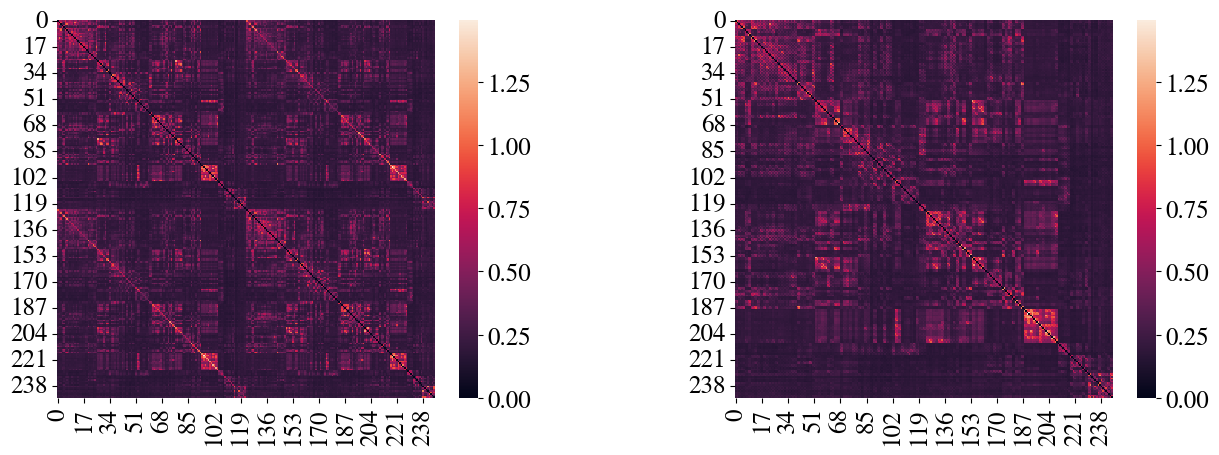

In [63]:
# let check fc, the order should be left-right-alternative
fcs = np.array([re["fc"] for re in res])

mfc = fcs.mean(axis=0)
idxs = np.concatenate([np.arange(0, 246, 2), np.arange(1, 246, 2)])
new_mfc = mfc[idxs][:, idxs]

plt.figure(figsize=[15, 5])
plt.subplot(121)
sns.heatmap(new_mfc, square=1)
plt.subplot(122)
sns.heatmap(mfc, square=1)

In [64]:
diag_labs = mat_data["dx_321"].reshape(-1)
sex_labs = mat_data["sex_321"].reshape(-1)
diag_lab_mapping = {
 1: "AD",
 2: "bvFTD",
 3: "CBS", 
 4: "nfvPPA", 
 5: "svPPA", 
 6: "HC"
}

In [65]:
metric = "tmC"
sub_ixs = np.array([re["sub_ix"] for re in res])
metrics = np.array([re["network_metrics"][metric] for re in res])
metrics = metrics[np.argsort(sub_ixs)]
res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
print(f"Metric is {metric}")
print(_get_test_tb(res_df))

Metric is tmC
+-----------------+--------+-------------+
|            Test |  Pval  | Effect size |
+-----------------+--------+-------------+
|        AD vs HC |  0.063 |    -0.276   |
|     bvFTD vs HC |  0.280 |    -0.200   |
|      *CBS vs HC |  0.043 |    -0.436   |
|    nfvPPA vs HC |  0.214 |    -0.247   |
|     svPPA vs HC |  0.471 |    -0.139   |
| *Dementia vs HC |  0.021 |    -0.277   |
|           ANOVA |  0.210 |             |
+-----------------+--------+-------------+


In [66]:
metric = "tmL"
sub_ixs = np.array([re["sub_ix"] for re in res])
metrics = np.array([re["network_metrics"][metric] for re in res])
metrics = metrics[np.argsort(sub_ixs)]
res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
print(f"Metric is {metric}")
print(_get_test_tb(res_df))

Metric is tmL
+----------------+--------+-------------+
|           Test |  Pval  | Effect size |
+----------------+--------+-------------+
|       AD vs HC |  0.183 |    -0.198   |
|    bvFTD vs HC |  0.544 |     0.113   |
|      CBS vs HC |  0.166 |    -0.300   |
|   nfvPPA vs HC |  0.087 |    -0.339   |
|    svPPA vs HC |  0.168 |    -0.265   |
| Dementia vs HC |  0.099 |    -0.198   |
|          ANOVA |  0.110 |             |
+----------------+--------+-------------+


In [67]:
metric = "tQ"
sub_ixs = np.array([re["sub_ix"] for re in res])
metrics = np.array([re["network_metrics"][metric] for re in res])
metrics = metrics[np.argsort(sub_ixs)]
res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
print(f"Metric is {metric}")
print(_get_test_tb(res_df))

Metric is tQ
+----------------+--------+-------------+
|           Test |  Pval  | Effect size |
+----------------+--------+-------------+
|       AD vs HC |  0.971 |    -0.005   |
|    bvFTD vs HC |  0.518 |     0.120   |
|      CBS vs HC |  0.178 |    -0.292   |
|   nfvPPA vs HC |  0.258 |    -0.224   |
|    svPPA vs HC |  0.297 |    -0.201   |
| Dementia vs HC |  0.481 |    -0.085   |
|          ANOVA |  0.369 |             |
+----------------+--------+-------------+


In [24]:
sub_ixs = np.array([re["sub_ix"] for re in res])
metricss = np.array([(re["network_metrics"]["tmC"], re["network_metrics"]["tmL"], re["network_metrics"]["tQ"])
                     for re in res])
metricss = metricss[np.argsort(sub_ixs)]
cmap = plt.cm.get_cmap('Set1')
cols = cmap(np.linspace(0, 1, len(set(diag_labs))))
graph_metric_labs = ["tmC", "tmL", "tQ"]

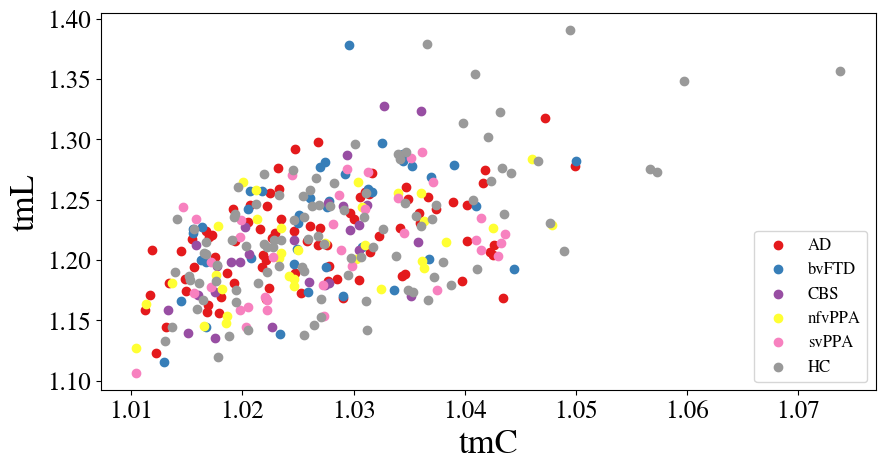

In [25]:
xix = 0
yix = 1
for ix in range(1, len(set(diag_labs))+1):
    plt.scatter(x=metricss[diag_labs==ix, xix], y=metricss[diag_labs==ix, yix], color=cols[ix-1], label=diag_lab_mapping[ix])
plt.xlabel(graph_metric_labs[xix])
plt.ylabel(graph_metric_labs[yix])
plt.legend(loc="lower right", fontsize=12)

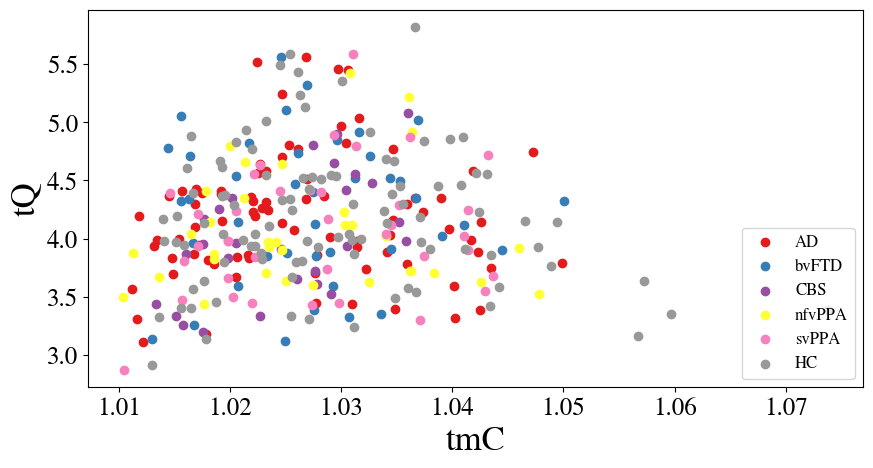

In [26]:
xix = 0
yix = 2
for ix in range(1, len(set(diag_labs))+1):
    plt.scatter(x=metricss[diag_labs==ix, xix], y=metricss[diag_labs==ix, yix], color=cols[ix-1], label=diag_lab_mapping[ix])
plt.xlabel(graph_metric_labs[xix])
plt.ylabel(graph_metric_labs[yix])
plt.legend(loc="lower right", fontsize=12)

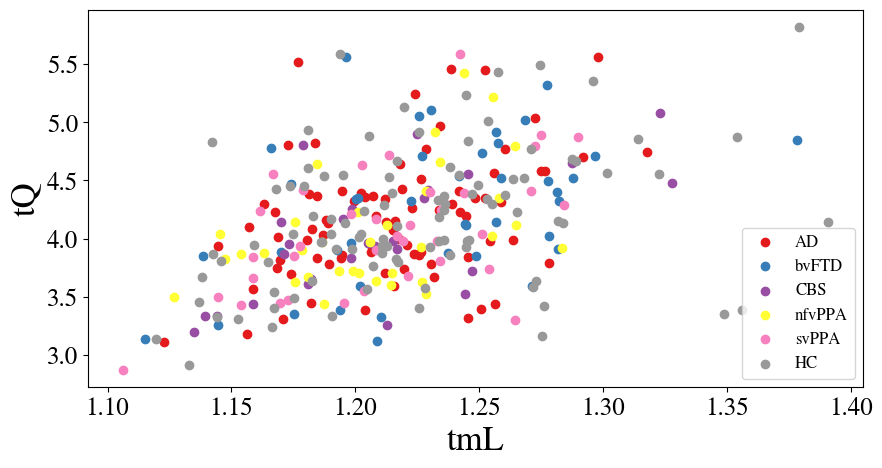

In [27]:
xix = 1
yix = 2
for ix in range(1, len(set(diag_labs))+1):
    plt.scatter(x=metricss[diag_labs==ix, xix], y=metricss[diag_labs==ix, yix], color=cols[ix-1], label=diag_lab_mapping[ix])
plt.xlabel(graph_metric_labs[xix])
plt.ylabel(graph_metric_labs[yix])
plt.legend(loc="lower right", fontsize=12)

# Get binary network(graph) metrics

In [15]:
def _run_fn(sub_ix):
    raw_ts = _load_data(sub_ix)[:num_rois]; # d x n
    ts = _preprocess_ts(raw_ts);
    fc = _get_binfc(ts)
    res = edict()
    res.sub_ix = sub_ix 
    res.fc = fc
    res.network_metrics = get_netmetrics_bin(fc)
    return res


In [16]:
with Parallel(n_jobs=15) as parallel:
    res = parallel(delayed(_run_fn)(sub_ix) for sub_ix in tqdm(range(1, num_sps+1), total=num_sps))

  5%|██████▍                                                                                                                                  | 15/321 [00:00<00:04, 64.99it/s]/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.

In [17]:
save_pkl(RES_ROOT/"graph_metrics_bfc.pkl", res, is_force=True)

Save to /MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_bfc.pkl


## Analysis

In [68]:
res = load_pkl(RES_ROOT/"graph_metrics_bfc.pkl");

Load file /MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_bfc.pkl


In [69]:
diag_labs = mat_data["dx_321"].reshape(-1)
sex_labs = mat_data["sex_321"].reshape(-1)
diag_lab_mapping = {
 1: "AD",
 2: "bvFTD",
 3: "CBS", 
 4: "nfvPPA", 
 5: "svPPA", 
 6: "HC"
}

In [70]:
metric = "tmC"
sub_ixs = np.array([re["sub_ix"] for re in res])
metrics = np.array([re["network_metrics"][metric] for re in res])
metrics = metrics[np.argsort(sub_ixs)]
res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
print(f"Metric is {metric}")
print(_get_test_tb(res_df))

Metric is tmC
+----------------+--------+-------------+
|           Test |  Pval  | Effect size |
+----------------+--------+-------------+
|       AD vs HC |  0.688 |     0.060   |
|    bvFTD vs HC |  0.544 |    -0.113   |
|      CBS vs HC |  0.697 |    -0.085   |
|   nfvPPA vs HC |  0.239 |    -0.233   |
|    svPPA vs HC |  0.159 |    -0.271   |
| Dementia vs HC |  0.445 |    -0.092   |
|          ANOVA |  0.475 |             |
+----------------+--------+-------------+


In [71]:
metric = "tmL"
sub_ixs = np.array([re["sub_ix"] for re in res])
metrics = np.array([re["network_metrics"][metric] for re in res])
metrics = metrics[np.argsort(sub_ixs)]
res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
print(f"Metric is {metric}")
print(_get_test_tb(res_df))

Metric is tmL
+----------------+--------+-------------+
|           Test |  Pval  | Effect size |
+----------------+--------+-------------+
|       AD vs HC |  0.160 |    -0.209   |
|    bvFTD vs HC |  0.629 |    -0.090   |
|      CBS vs HC |  0.443 |    -0.167   |
|   nfvPPA vs HC |  0.251 |    -0.228   |
|    svPPA vs HC |  0.171 |    -0.263   |
| Dementia vs HC |  0.061 |    -0.225   |
|          ANOVA |  0.489 |             |
+----------------+--------+-------------+


In [72]:
metric = "tQ"
sub_ixs = np.array([re["sub_ix"] for re in res])
metrics = np.array([re["network_metrics"][metric] for re in res])
metrics = metrics[np.argsort(sub_ixs)]
res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
print(f"Metric is {metric}")
print(_get_test_tb(res_df))

Metric is tQ
+-----------------+--------+-------------+
|            Test |  Pval  | Effect size |
+-----------------+--------+-------------+
|       *AD vs HC |  0.008 |     0.392   |
|     bvFTD vs HC |  0.096 |     0.308   |
|       CBS vs HC |  0.194 |     0.281   |
|    nfvPPA vs HC |  0.325 |     0.195   |
|     svPPA vs HC |  0.928 |     0.017   |
| *Dementia vs HC |  0.015 |     0.292   |
|           ANOVA |  0.065 |             |
+-----------------+--------+-------------+


In [35]:
sub_ixs = np.array([re["sub_ix"] for re in res])
metricss = np.array([(re["network_metrics"]["tmC"], re["network_metrics"]["tmL"], re["network_metrics"]["tQ"])
                     for re in res])
metricss = metricss[np.argsort(sub_ixs)]
cmap = plt.cm.get_cmap('Set1')
cols = cmap(np.linspace(0, 1, len(set(diag_labs))))
graph_metric_labs = ["tmC", "tmL", "tQ"]

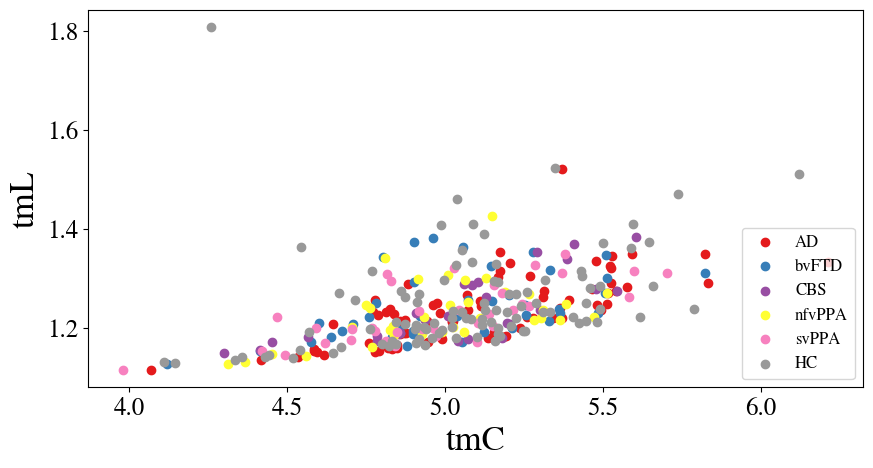

In [36]:
xix = 0
yix = 1
for ix in range(1, len(set(diag_labs))+1):
    plt.scatter(x=metricss[diag_labs==ix, xix], y=metricss[diag_labs==ix, yix], color=cols[ix-1], label=diag_lab_mapping[ix])
plt.xlabel(graph_metric_labs[xix])
plt.ylabel(graph_metric_labs[yix])
plt.legend(loc="lower right", fontsize=12)

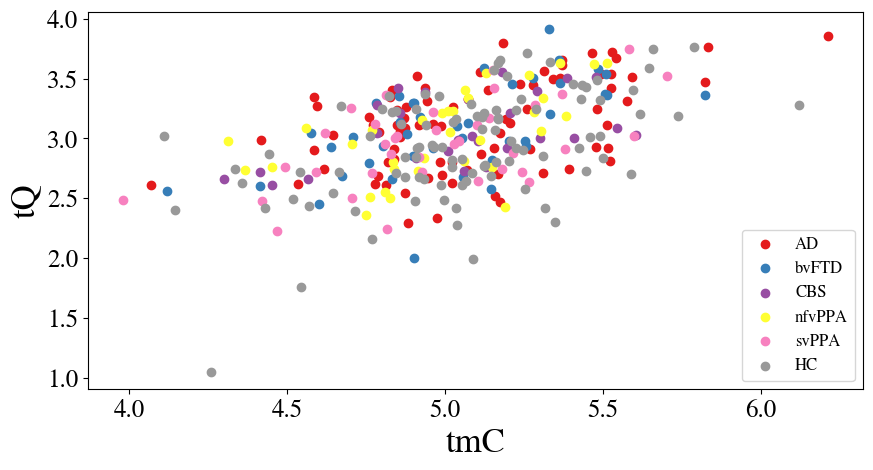

In [37]:
xix = 0
yix = 2
for ix in range(1, len(set(diag_labs))+1):
    plt.scatter(x=metricss[diag_labs==ix, xix], y=metricss[diag_labs==ix, yix], color=cols[ix-1], label=diag_lab_mapping[ix])
plt.xlabel(graph_metric_labs[xix])
plt.ylabel(graph_metric_labs[yix])
plt.legend(loc="lower right", fontsize=12)

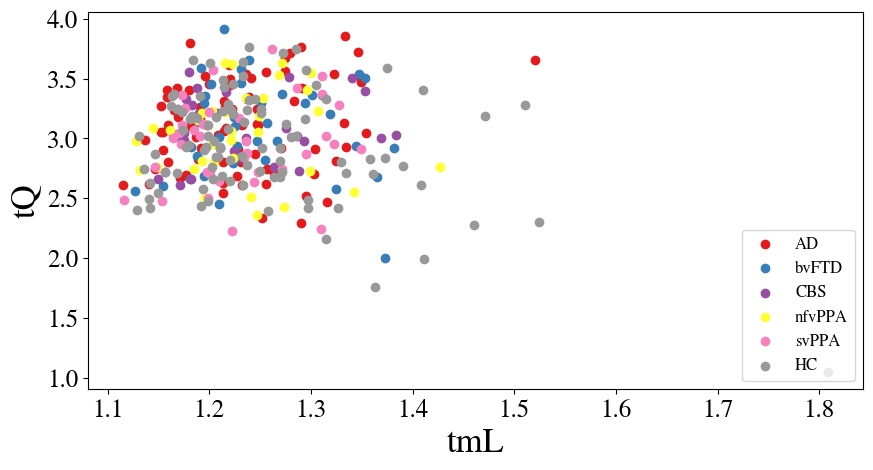

In [38]:
xix = 1
yix = 2
for ix in range(1, len(set(diag_labs))+1):
    plt.scatter(x=metricss[diag_labs==ix, xix], y=metricss[diag_labs==ix, yix], color=cols[ix-1], label=diag_lab_mapping[ix])
plt.xlabel(graph_metric_labs[xix])
plt.ylabel(graph_metric_labs[yix])
plt.legend(loc="lower right", fontsize=12)

# Get ball corr FC 

In [39]:
def get_bcorr_FC(ts, verbose=False):
    """
    Calculates the ball correlation functional connectivity (bcorrFC) for a given time series.

    Parameters:
    ts (numpy.ndarray): A 2D numpy array of shape (num_rois, num_timepoints) containing the time series data.
    verbose (bool): If True, displays a progress bar while the function is running. Default is False.

    Returns:
    numpy.ndarray: A 2D numpy array of shape (num_rois, num_rois) containing the bcorrFC values.
                   The diag terms are 0.
    """
    num_rois = ts.shape[0]
    bcorFC = np.zeros((num_rois, num_rois));
    rixs, cixs = np.triu_indices(num_rois, k=1)
    def _run_fn(cix, rix, ts):
        return get_ball_cor(ts[rix], ts[cix])
    if verbose:
        pbar = tqdm(zip(rixs, cixs), total=len(rixs))
    else:
        pbar = zip(rixs, cixs)
    with Parallel(n_jobs=20) as parallel:
        bcors = parallel(delayed(_run_fn)(rix, cix, ts) for rix, cix in pbar)
    bcorFC[(rixs, cixs)] = np.array(bcors)
    bcorFC = bcorFC + bcorFC.T
    return bcorFC

In [10]:
bcorFCs = load_pkl(RES_ROOT/"bcorFCs.pkl");

Load file /MyResearch/jesse_data/notebooks/../mypkg/../results/bcorFCs.pkl


In [11]:
def _run_fn(sub_ix):
    bfc = bcorFCs[sub_ix-1]
    res = edict()
    res.sub_ix = sub_ix 
    res.fc = bfc 
    res.network_metrics = get_netmetrics(bfc)
    return res
with Parallel(n_jobs=15) as parallel:
    res = parallel(delayed(_run_fn)(sub_ix) for sub_ix in tqdm(range(1, num_sps+1), total=num_sps))
save_pkl(RES_ROOT/"graph_metrics_ballfc.pkl", res, is_force=True)

  5%|██████▍                                                                                                                                  | 15/321 [00:00<00:06, 44.40it/s]/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.

 42%|█████████████████████████████████████████████████████████▏                                                                              | 135/321 [29:20<45:38, 14.72s/it]/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
 56%|████████████████████████████████████████████████████████████████████████████▎                                                           | 180/321 [40:35<35:28, 15.10s/it]/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do

Save to /MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_ballfc.pkl


In [ ]:
def _run_fn(sub_ix):
    bfc = bcorFCs[sub_ix-1]
    bbinfc = bin_fc(bfc)
    res = edict()
    res.sub_ix = sub_ix 
    res.fc = bbinfc
    res.network_metrics = get_netmetrics_bin(bbinfc)
    return res
with Parallel(n_jobs=15) as parallel:
    res = parallel(delayed(_run_fn)(sub_ix) for sub_ix in tqdm(range(1, num_sps+1), total=num_sps))
save_pkl(RES_ROOT/"graph_metrics_bbinfc.pkl", res, is_force=True)

## Analysis

### Bin FC

In [73]:
res = load_pkl(RES_ROOT/"graph_metrics_bbinfc.pkl");
diag_labs = mat_data["dx_321"].reshape(-1)
sex_labs = mat_data["sex_321"].reshape(-1)
diag_lab_mapping = {
 1: "AD",
 2: "bvFTD",
 3: "CBS", 
 4: "nfvPPA", 
 5: "svPPA", 
 6: "HC"
}


Load file /MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_bbinfc.pkl


In [74]:
metric = "tmC"
sub_ixs = np.array([re["sub_ix"] for re in res])
metrics = np.array([re["network_metrics"][metric] for re in res])
metrics = metrics[np.argsort(sub_ixs)]
res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
print(f"Metric is {metric}")
print(_get_test_tb(res_df))

Metric is tmC
+----------------+--------+-------------+
|           Test |  Pval  | Effect size |
+----------------+--------+-------------+
|       AD vs HC |  0.524 |    -0.095   |
|    bvFTD vs HC |  0.226 |    -0.224   |
|      CBS vs HC |  0.105 |    -0.350   |
|   nfvPPA vs HC |  0.064 |    -0.366   |
|    svPPA vs HC |  0.163 |    -0.268   |
| Dementia vs HC |  0.059 |    -0.227   |
|          ANOVA |  0.278 |             |
+----------------+--------+-------------+


In [75]:
metric = "tmL"
sub_ixs = np.array([re["sub_ix"] for re in res])
metrics = np.array([re["network_metrics"][metric] for re in res])
metrics = metrics[np.argsort(sub_ixs)]
res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
print(f"Metric is {metric}")
print(_get_test_tb(res_df))

Metric is tmL
+-----------------+--------+-------------+
|            Test |  Pval  | Effect size |
+-----------------+--------+-------------+
|       *AD vs HC |  0.026 |    -0.331   |
|     bvFTD vs HC |  0.313 |    -0.187   |
|       CBS vs HC |  0.058 |    -0.409   |
|    nfvPPA vs HC |  0.072 |    -0.355   |
|     svPPA vs HC |  0.101 |    -0.315   |
| *Dementia vs HC |  0.002 |    -0.366   |
|           ANOVA |  0.055 |             |
+-----------------+--------+-------------+


In [76]:
metric = "tQ"
sub_ixs = np.array([re["sub_ix"] for re in res])
metrics = np.array([re["network_metrics"][metric] for re in res])
metrics = metrics[np.argsort(sub_ixs)]
res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
print(f"Metric is {metric}")
print(_get_test_tb(res_df))

Metric is tQ
+----------------+--------+-------------+
|           Test |  Pval  | Effect size |
+----------------+--------+-------------+
|       AD vs HC |  0.125 |     0.228   |
|    bvFTD vs HC |  0.291 |     0.196   |
|      CBS vs HC |  0.902 |     0.027   |
|   nfvPPA vs HC |  0.797 |    -0.051   |
|    svPPA vs HC |  0.695 |    -0.075   |
| Dementia vs HC |  0.367 |     0.109   |
|          ANOVA |  0.414 |             |
+----------------+--------+-------------+


### FC

In [57]:
res = load_pkl(RES_ROOT/"graph_metrics_ballfc.pkl");
diag_labs = mat_data["dx_321"].reshape(-1)
sex_labs = mat_data["sex_321"].reshape(-1)
diag_lab_mapping = {
 1: "AD",
 2: "bvFTD",
 3: "CBS", 
 4: "nfvPPA", 
 5: "svPPA", 
 6: "HC"
}


Load file /MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_ballfc.pkl


In [58]:
metric = "tmC"
sub_ixs = np.array([re["sub_ix"] for re in res])
metrics = np.array([re["network_metrics"][metric] for re in res])
metrics = metrics[np.argsort(sub_ixs)]
res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
print(f"Metric is {metric}")
print(_get_test_tb(res_df))

Metric is tmC
+-----------------+--------+-------------+
|            Test |  Pval  | Effect size |
+-----------------+--------+-------------+
|       *AD vs HC |  0.032 |    -0.318   |
|     bvFTD vs HC |  0.140 |    -0.273   |
|       CBS vs HC |  0.060 |    -0.406   |
|    nfvPPA vs HC |  0.101 |    -0.324   |
|     svPPA vs HC |  0.132 |    -0.289   |
| *Dementia vs HC |  0.002 |    -0.368   |
|           ANOVA |  0.077 |             |
+-----------------+--------+-------------+


In [59]:
metric = "tmL"
sub_ixs = np.array([re["sub_ix"] for re in res])
metrics = np.array([re["network_metrics"][metric] for re in res])
metrics = metrics[np.argsort(sub_ixs)]
res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
print(f"Metric is {metric}")
print(_get_test_tb(res_df))

Metric is tmL
+----------------+--------+-------------+
|           Test |  Pval  | Effect size |
+----------------+--------+-------------+
|       AD vs HC |  0.157 |    -0.210   |
|    bvFTD vs HC |  0.612 |     0.094   |
|      CBS vs HC |  0.206 |    -0.274   |
|   nfvPPA vs HC |  0.052 |    -0.383   |
|    svPPA vs HC |  0.185 |    -0.255   |
| Dementia vs HC |  0.086 |    -0.207   |
|          ANOVA |  0.105 |             |
+----------------+--------+-------------+


In [60]:
metric = "tQ"
sub_ixs = np.array([re["sub_ix"] for re in res])
metrics = np.array([re["network_metrics"][metric] for re in res])
metrics = metrics[np.argsort(sub_ixs)]
res_df = pd.DataFrame({
    "metric": metrics, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
print(f"Metric is {metric}")
print(_get_test_tb(res_df))

Metric is tQ
+----------------+--------+-------------+
|           Test |  Pval  | Effect size |
+----------------+--------+-------------+
|       AD vs HC |  0.378 |    -0.131   |
|    bvFTD vs HC |  0.798 |    -0.048   |
|      CBS vs HC |  0.374 |    -0.193   |
|   nfvPPA vs HC |  0.452 |    -0.149   |
|    svPPA vs HC |  0.263 |    -0.215   |
| Dementia vs HC |  0.234 |    -0.144   |
|          ANOVA |  0.836 |             |
+----------------+--------+-------------+
